# CMA-ES bare-bones reimplementation

Tests for the experimental CMA-ES reimplementation.

We start by visually inspecting its behaviour on selected problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.toy
import pints.cptests.cmaes_bare as cp

from utils import (
    function,
    function_between_points,
    technicolor_dreamline,
    run_replicates,
)

method = pints.BareCMAES
parallel = True

## Logistic model - no transformations


In [2]:
model = pints.toy.LogisticModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
values += np.random.normal(0, 5, values.shape)
problem = pints.SingleOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [0, 0.5]
ylim = [10, 100]
boundaries = pints.RectangularBoundaries(
    [xlim[0], ylim[0]], [xlim[1], ylim[1]])

x0 = boundaries.sample(1)[0]

In [3]:
controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(False)  # This is faster

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Bare-bones CMA-ES
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     5      110475.9  110475.9   0:00.0
1     11     89485.17  89485.17   0:00.0
2     16     26754.28  26754.28   0:00.0
3     20     14607.65  14607.65   0:00.0
20    106    13626.7   13780.2    0:00.0
40    226    13569.16  13569.16   0:00.0
60    346    12959.84  12959.84   0:00.0
80    466    2814.863  2814.863   0:00.0
100   586    2811.257  2811.277   0:00.1
120   706    2811.255  2811.255   0:00.1
140   826    2811.255  2811.255   0:00.1
160   946    2811.255  2811.255   0:00.1
180   1066   2811.255  2811.255   0:00.1
200   1186   2811.255  2811.255   0:00.1
220   1306   2811.255  2811.255   0:00.1
240   1426   2811.255  2811.255   0:00.1
260   1546   2811.255  2811.255   0:00.1
280   1666   2811.255  2811.255   0:00.1
300   1786   2811.255  2811.255   0:00.2
320   1906   2811.255  2811.255   0:00.2
340   2026   2811.255  2811.255   0:00.2
35

  Found       xbest        Relative error
   1.004e-01   1.000e-01   0.375% 
   5.055e+01   5.000e+01   1.099% 



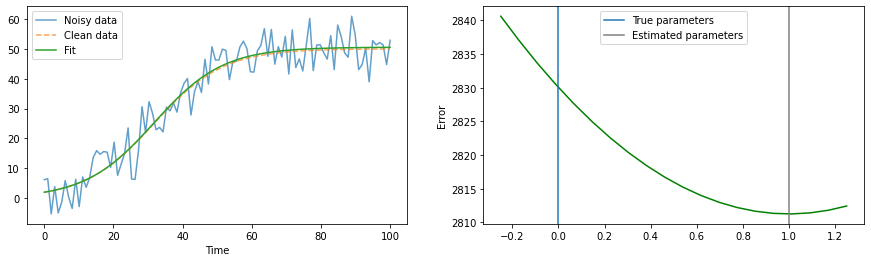

In [4]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

Works well!

### Detailed run

In [5]:
x0 = [0.4, 90]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(80):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

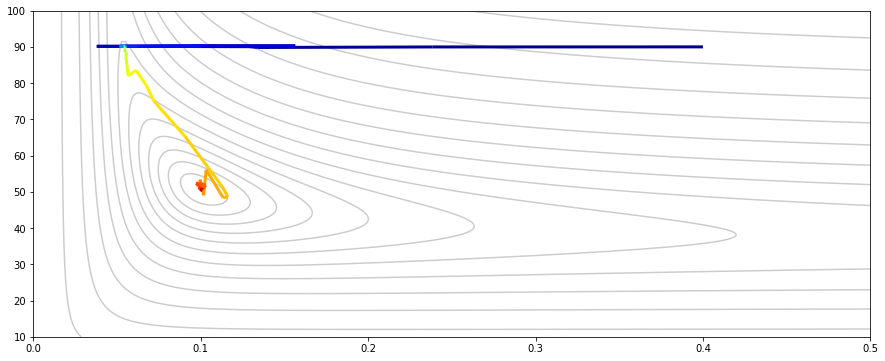

In [6]:
# Create points for contour plot of marginal density
levels = np.geomspace(1e3, 4e5, 20)
x = np.linspace(*xlim, 200)
y = np.linspace(*ylim, 150)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

This looks very similar to wrapped CMA-ES.

## Neal's funnel

In [7]:
log_pdf = pints.toy.NealsFunnelLogPDF()
x0 = 9 * np.ones(10, dtype=float)
x0[-1] = 7

opt = method(x0)
walk = [x0]
for i in range(200):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

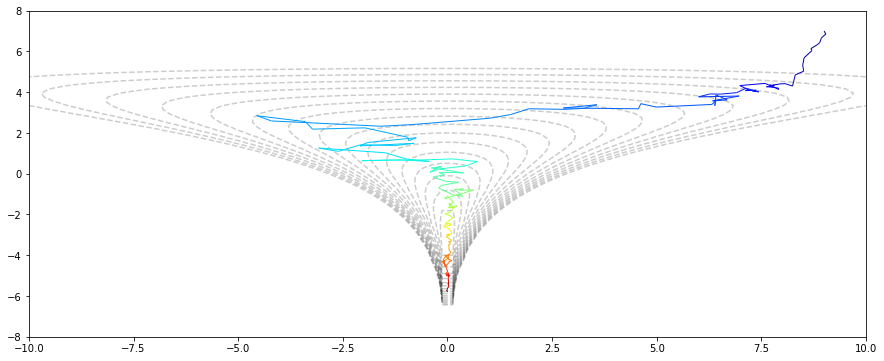

In [8]:
# Create points for contour plot of marginal density
xlim = -10, 10
ylim = -8, 8
levels = np.linspace(-7, -1, 20)
x = np.linspace(*xlim, 80)
y = np.linspace(*ylim, 80)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Again it looks good and very much the same.

## Rosenbrock function

In [9]:
error = pints.toy.RosenbrockError()
x0 = [-4, -2]

opt = method(x0)
walk = [x0]
for i in range(150):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

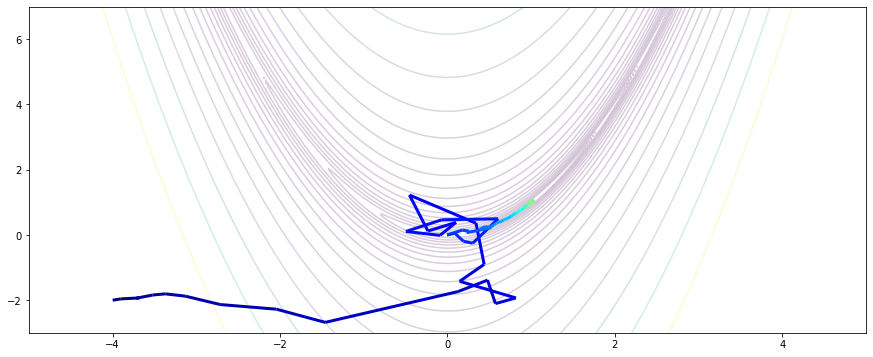

In [10]:
# Create points for contour plot of marginal density
xlim = [-5, 5]
ylim = [-3, 7]
levels = np.geomspace(1, 1e4, 20) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Zoom view:

1.585968797665864e-08 0.022600062864384853


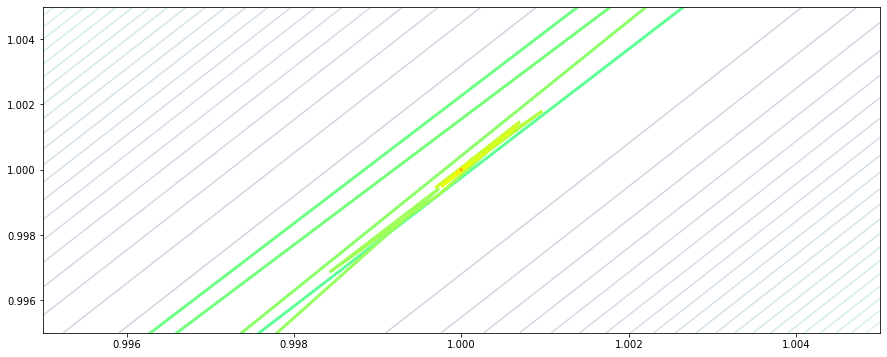

In [11]:
# Create points for contour plot of marginal density
xbest = walk[-1, :]
xlim = [xbest[0] - 0.005, xbest[0] + 0.005]
ylim = [xbest[1] - 0.005, xbest[1] + 0.005]
levels = np.geomspace(1, 1.03, 30) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

print(np.min(Z), np.max(Z))

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

## Fitzhugh-Nagumo model - fully observable

In [12]:
model = pints.toy.FitzhughNagumoModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
r = np.random.default_rng(1)  # Create a seeded generator to get reproducible noise
values += r.normal(0, 0.5, values.shape)
problem = pints.MultiOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [1e-3, 2]
ylim = [1e-3, 2]
zlim = [1e-3, 10]
boundaries = np.vstack((xlim, ylim, zlim)).T
boundaries = pints.RectangularBoundaries(boundaries[0], boundaries[1])

In [13]:
# Use a fixed starting point for this one
x0 = xtrue * 1.3

controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(parallel)

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Bare-bones CMA-ES
Running in parallel with 7 worker processes.
Population size: 7
Iter. Eval. Best      Current   Time    
0     3      344.7923  344.7923   0:00.1
1     9      282.3521  282.3521   0:00.2
2     14     101.0357  101.0357   0:00.3
3     17     101.0357  116.6388   0:00.4
20    129    84.11825  84.19324   0:01.3
40    269    83.07294  83.07294   0:02.5
60    409    83.07135  83.07135   0:03.6
80    549    83.07134  83.07134   0:04.8
100   689    83.07134  83.07134   0:06.0
120   829    83.07134  83.07134   0:07.1
140   969    83.07134  83.07134   0:08.3
160   1109   83.07134  83.07134   0:09.4
180   1249   83.07134  83.07134   0:10.6
200   1389   83.07134  83.07134   0:11.3
220   1529   83.07134  83.07134   0:11.9
240   1669   83.07134  83.07134   0:12.5
260   1809   83.07134  83.07134   0:13.1
280   1949   83.07134  83.07134   0:13.8
281   1949   83.07134  83.07134   0:13.8
Halting: No significant change for 200 iterations.
14.35 seconds


  Found       xbest        Relative error
   8.712e-02   1.000e-01  -12.878% 
   5.733e-01   5.000e-01   14.664% 
   2.929e+00   3.000e+00  -2.359% 



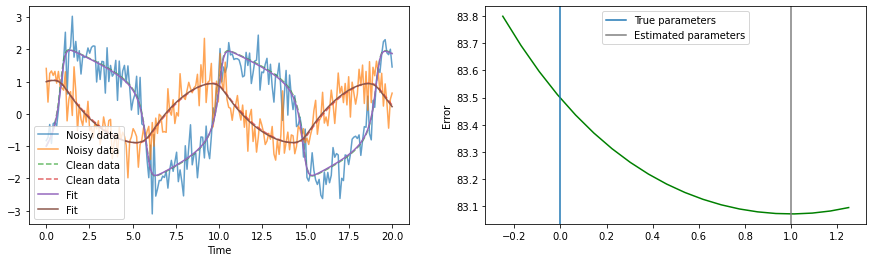

In [14]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

As with CMAES, we see rapid convergence from the chosen starting point.

### Detailed run

In [15]:
# Create points for contour plot of marginal density
def contour(xlim, ylim, idx):
    n = 80
    x = np.linspace(*xlim, n)
    y = np.linspace(*ylim, n)
    X, Y = np.meshgrid(x, y)
    Z = [[error(idx(i, j)) for i in x] for j in y]
    return X, Y, Z

n = 100
X1, Y1, Z1 = contour(xlim, ylim, idx=lambda i, j: [i, j, xtrue[2]])
levels1 = np.geomspace(95, 1250, n)
X2, Y2, Z2 = contour(xlim, zlim, idx=lambda i, j: [i, xtrue[1], j])
levels2 = np.geomspace(95, 1000, n)
X3, Y3, Z3 = contour(ylim, zlim, idx=lambda i, j: [xtrue[0], i, j])
levels3 = np.geomspace(95, 1e3, n)

83.59882874778327 1535.472422939695
84.28386356034511 7589.604854692392
83.40920637194193 6013931.213248802


In [16]:
np.random.seed(1)
x0 = [0.75, 1.5, 3]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(400):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)
np.random.seed()

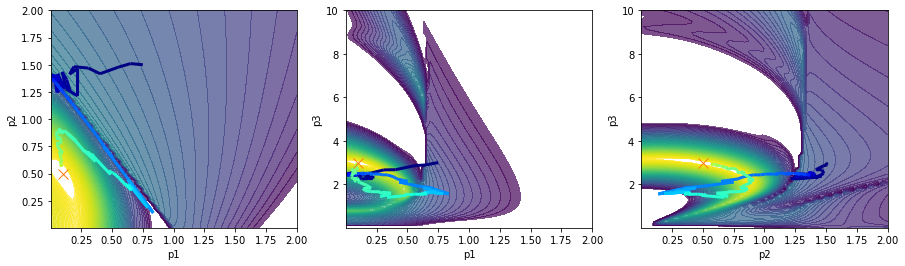

In [17]:
# Plot contours and optimiser progress
def fig3():
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.contourf(X1, Y1, Z1, levels=levels1, cmap='viridis_r', alpha=0.7)
    ax1.set_xlim(*xlim); ax1.set_ylim(*ylim)
    ax1.set_xlabel('p1'); ax1.set_ylabel('p2')
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.contourf(X2, Y2, Z2, levels=levels2, cmap='viridis_r', alpha=0.7)
    ax2.set_xlim(*xlim); ax2.set_ylim(*zlim)
    ax2.set_xlabel('p1'); ax2.set_ylabel('p3')
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.contourf(X3, Y3, Z3, levels=levels3, cmap='viridis_r', alpha=0.7)
    ax3.set_xlim(*ylim); ax3.set_ylim(*zlim)
    ax3.set_xlabel('p2'); ax3.set_ylabel('p3')
    return fig, ax1, ax2, ax3

def p3(ax1, ax2, ax3, x, marker='x', markersize=10, color=None):
    ax1.plot(x[0], x[1], marker, markersize=markersize, color=color)
    ax2.plot(x[0], x[2], marker, markersize=markersize, color=color)
    ax3.plot(x[1], x[2], marker, markersize=markersize, color=color)

fig, ax1, ax2, ax3 = fig3()
technicolor_dreamline(ax1, walk[:, 0], walk[:, 1], lw=3)
technicolor_dreamline(ax2, walk[:, 0], walk[:, 2], lw=3)
technicolor_dreamline(ax3, walk[:, 1], walk[:, 2], lw=3)
p3(ax1, ax2, ax3, xtrue)

plt.show()

# Testing performance

## 2D Parabola

If this doesn't work, something is broken.

In [18]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 20), 20, cp.two_dim_parabola, parallel)
print(t.format())

0.9 seconds


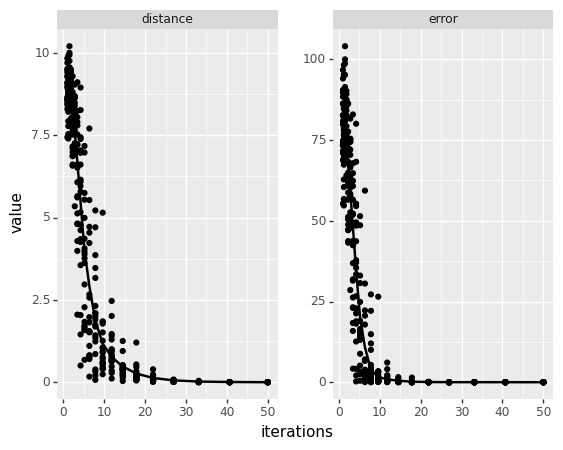

<ggplot: (8769306198589)>

In [19]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.25, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Both lines move in the right direction, and the error quickly goes to zero.

## Rosenbrock function

In [20]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 150, 30), 10, cp.rosenbrock, parallel)
print(t.format())

1.03 seconds


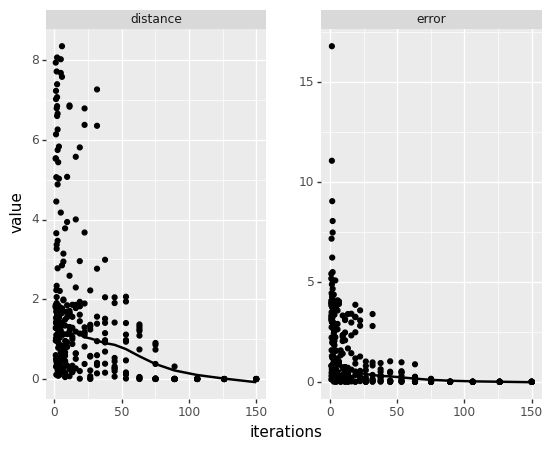

<ggplot: (8769324559753)>

In [21]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

## Bounded, untransformed logistic model

In [22]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 300, 30), 10, cp.bounded_untransformed_logistic, parallel)
print(t.format())

2.08 seconds


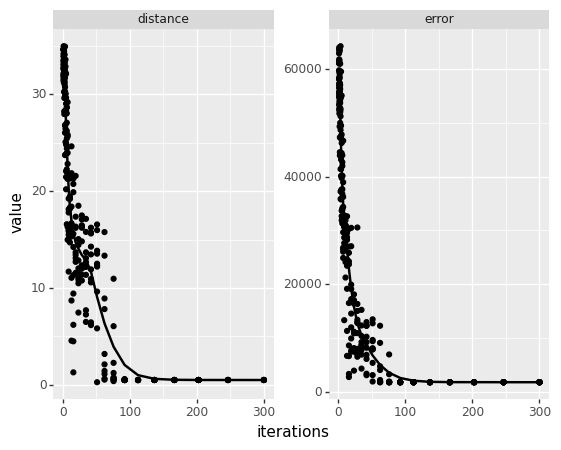

<ggplot: (8769305096221)>

In [23]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Looks good!

## Bounded Fitzhugh-Nagumo

In [24]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 10), 10, cp.bounded_fitzhugh_nagumo, parallel)
print(t.format())

5.05 seconds


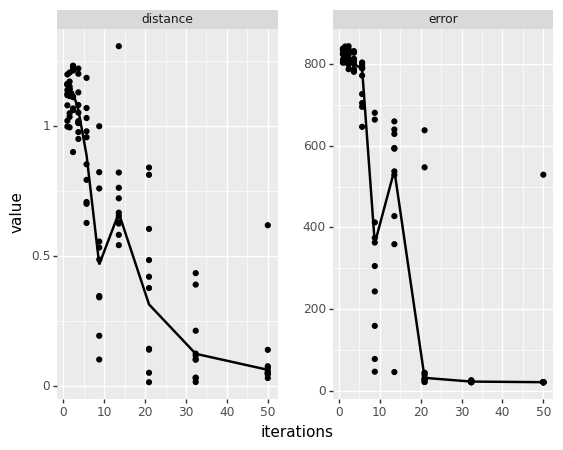

<ggplot: (8769306076253)>

In [25]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

This is an interesting test!

- Convergence is all-or-nothing: Either it gets to almost the right answer in 10-20 iterations, or it gets stuck somewhere (if you don't see any failing examples, try re-running).
- Many runs show an increased distance from ~30 to ~50 iterations: this is presumably the optimiser overfitting to the noise.